<a href="https://colab.research.google.com/github/hasanihardik/Nifty50-Forecasting/blob/main/Forecasting_Nifty_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##  Objective :
* ### To perform time series analysis on the NIFTY stock price and forecasting using univariate ARIMA and ARIMAX modeling technique.

* ### We further simplified the problem  to  predict the direction of Close price  movements in the next N days (throughout our experiments N can take values 1, 5, and 30). Initially, we will take N=1, that means we want to predict the NIFTY 50  Close price  movement in the next day. This is represented as a classification task where there are two possible outcomes (either the index went up in the next day or it went down).



## Importing libararies

In [1]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.0 MB/s eta 0:00:00


In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
import matplotlib.dates as mdates
import scipy.stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pylab
sns.set(style='white')
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm as lgb
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product                   # some useful functions
from tqdm import tqdm_notebook

%matplotlib inline

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


##Dataset Details

We contain dataset of daily stock prices of Nifty50 from  3rd January 2000 to  10th May 2021.

*The **NIFTY 50** is a benchmark Indian stock market index that represents the weighted average of 50 of the largest Indian companies listed on the National Stock Exchange.*

Description of columns in the Dataset:

* Date — Date of trade
* Open — The open is the starting period of trading on a securities exchange or organized over-the-counter market.
* High — Highest price at which a stock traded during the course of the trading day.
* Low — Lowest price at which a stock traded during the course of the trading day.
* Close — The close is a reference to the end of a trading session in the financial markets when the markets close for the day.

## Loading Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NIFTY50_Data.csv')


In [9]:
df.head()

,Date,Open,High,Low,Close
0,05 Jul 2019,11964.75,11981.75,11797.90,11811.15
1,04 Jul 2019,11928.80,11969.25,11923.65,11946.75
2,03 Jul 2019,11932.15,11945.20,11887.05,11916.75
3,02 Jul 2019,11890.30,11917.45,11814.70,11910.30
4,01 Jul 2019,11839.90,11884.65,11830.80,11865.60


#### Understanding the dataset

In [10]:
# Get a brief summary on the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    495 non-null    object 
 1   Open    495 non-null    float64
 2   High    495 non-null    float64
 3   Low     495 non-null    float64
 4   Close   495 non-null    float64
dtypes: float64(4), object(1)
memory usage: 19.5+ KB


In [11]:
#Finding count of null values for each columns
df.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0


We have observed that-
* There were 35 null values in initial dataframe which includes the date when the trading didn't happen.
* All null values rows are droped from the dataset for further analysis.
* The data now have 5266 rows and 5 columns.

In [12]:
#Droping Null values
df.dropna(inplace=True)

In [13]:
# Checking for null value
df.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0


In [14]:
# Get updated dataset size
df.shape

(495, 5)

# EDA

### Get dataset statistical summary

In [16]:
#Describe the data set
df.describe()

,Open,High,Low,Close
count,495.000000,495.000000,495.000000,495.000000
mean,10751.940202,10793.314646,10690.846364,10742.551010
std,578.979690,581.244343,572.550490,576.495874
min,9653.600000,9684.250000,9639.950000,9665.800000
25%,10331.700000,10370.900000,10269.950000,10324.100000
50%,10699.700000,10741.050000,10628.650000,10684.650000
75%,11078.650000,11117.725000,11010.075000,11069.525000
max,12052.650000,12103.050000,12005.850000,12088.550000


#### Understanding of summary

We can conclude that each feature has similar type of statistical measurement.
* Mean and median of each feature is close for  all features
* Standard deviation is also somewhat similar in all features

## Visualization


In [17]:
# Change data type of Date column into datetime
df['Date']= pd.to_datetime(df['Date'])

In [18]:
df.set_index('Date',inplace=True)

#### Get Line plot of features with respect to Date.

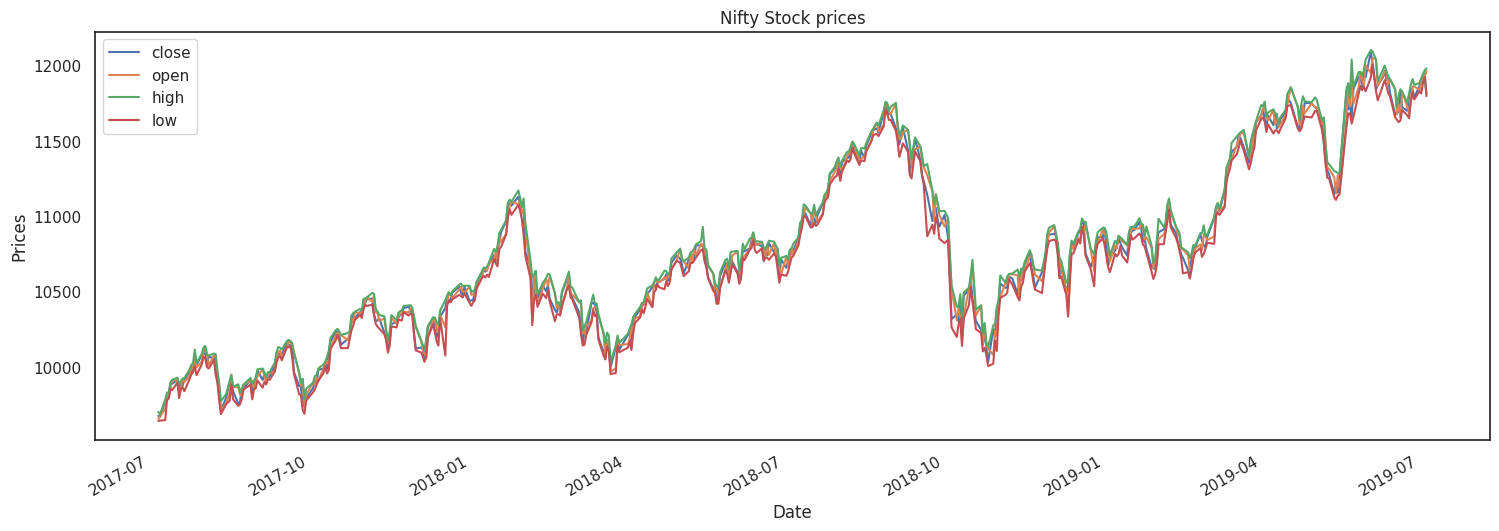

In [19]:
#Multi Line plot
plt.subplots(figsize=(18,6))
plt.xlabel('Date')
plt.ylabel('Prices')
df['Close'].plot(label='close')
df['Open'].plot(label='open')
df['High'].plot(label='high')
df['Low'].plot(label='low')
plt.legend()
plt.title('Nifty Stock prices')
plt.show()

From the above graphs, we have observed that-
* There is a drastic drop in stock prices in 2007-2009 period.This  can be attributed to the Great Recession that happened during this period.
* There is a drop in stock prices in the year 2016. This can be attributed to Demonitisation drive by the central government.

* There is a drastic drop in stock prices in 2020. This is due to the global breakdown amid coronavirus pandemic induced lockdown in India.

* By the end of 2020, the stock price started rising.This can be attributed to the lifting of lockdown in the country and across the world.

## Forcasting using univarate ARIMA and ARIMAX modeling technique

## Decomposition

We will do is decomposition of time series to find the Trend, Seasonality , residual in our data.

In [20]:
# Decomposition
result = seasonal_decompose(df['Close'], model='additive',freq=1)
result.plot()
plt.show()

TypeError: seasonal_decompose() got an unexpected keyword argument 'freq'

From above decomposition we can conclude-
* Trend is increasing
* No seasonality in the data
* No residual in data

## Checking randomness in data.

In time series problem we need to make sure that our current day data is related to previous data points and these data points should not be random. If data points are randomly selected than it become hard to forcast.




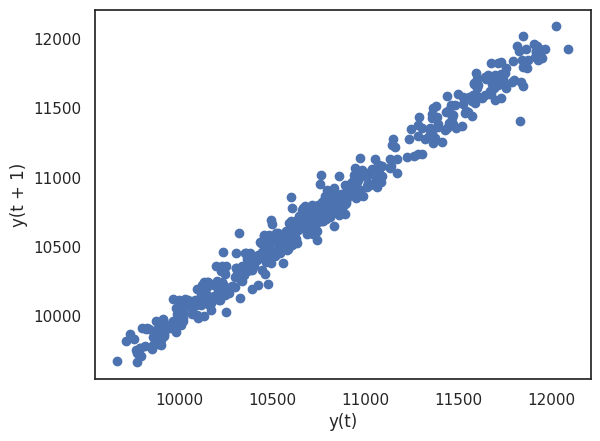

In [21]:
# Lag plot
from pandas.plotting import lag_plot
lag_plot(df['Close'])
plt.show()

Here,we can see that our previous day data and current day data is linearly related.

##  Checking Stationarity
  We can check stationarity with the help of adfuller.

* Null Hypothesis ($H_o $) is that our data is Non-stationary
* Alternative Hypothesis ($H_1)$  that our data is Statinary

In [22]:
#  Function to check stationary of data using ADF
def adfuller_test(sales):
  result=adfuller(sales)
  labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
  for value,label in zip(result,labels):
      print(label+' : '+str(value) )

  if result[1] <= 0.05:
      print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
  else:
      print("weak evidence against null hypothesis,indicating it is non-stationary ")

In [23]:

#  Function to plot Autocorrealtion and partial corelation

def cor_plots(x):
  fig = plt.figure(figsize=(12,8))
  ax1 = fig.add_subplot(211)
  fig = sm.graphics.tsa.plot_acf(df[x].dropna(),lags=24,ax=ax1)
  ax2 = fig.add_subplot(212)
  fig = sm.graphics.tsa.plot_pacf(df[x].dropna(),lags=24,ax=ax2)

In [24]:
# Check stationary on Close feature
adfuller_test(df['Close'])

ADF Test Statistic : -1.8977190524508996
p-value : 0.33313490012938096
#Lags Used : 2
Number of Observations : 492
weak evidence against null hypothesis,indicating it is non-stationary 


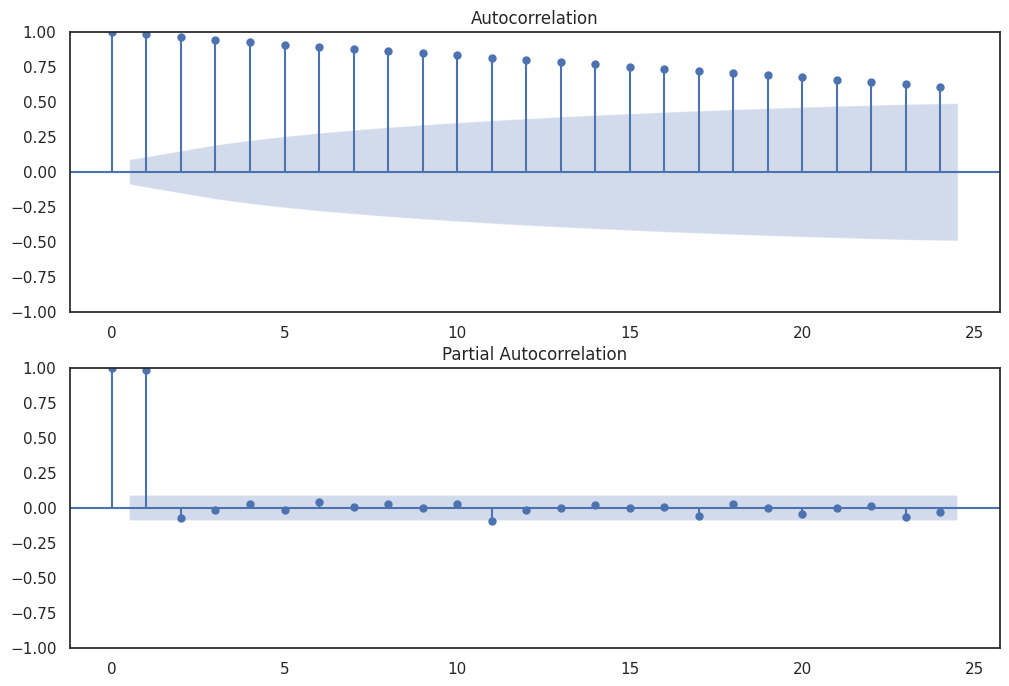

In [25]:
# Get Autocorrelation plot
cor_plots('Close')

We dont have enogh evidence to reject null hypothesis as p- value is greater than threshold.

Our close price data is Non- stationary.



### Checking with stationarity of the first difference:

We try to modify our data by taking first differnece on closing price.

In [26]:
#Apply adf test on the first difference closing price series
df['Close First Difference'] = df['Close'] - df['Close'].shift(1)

In [27]:
# Get stationary on first difference closing price
adfuller_test(df['Close First Difference'].dropna())

ADF Test Statistic : -20.895660397761063
p-value : 0.0
#Lags Used : 0
Number of Observations : 493
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


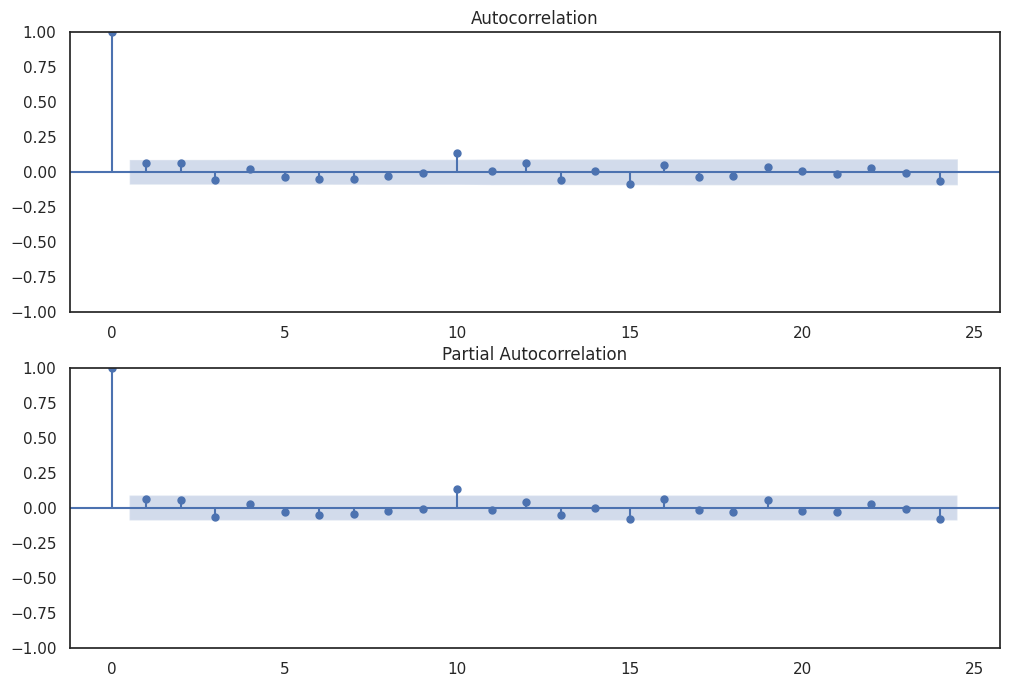

In [28]:
# Get autocorrelation plot
cor_plots('Close First Difference')

In [29]:
# Close variable over time on differncing
import plotly.graph_objects as go
fig = go.Figure([go.Scatter(x=df.index,y=df['Close First Difference'])])
fig.update_layout(width=1000, height=500,
    title='Close variable over time on differencing ')
fig.show()


###Feature Engineering

In [30]:
# Create a copy of df
final_df = df.copy()

We will be creating new features to train are model as we just have 4 feature in data set.

### Moving average and Exponential weight moving average

* Moving average (MA) is a widely used technical indicator that smooths out price trends by filtering out the “noise” from random short-term price fluctuations.

* Moving averages can be constructed in several different ways, and employ different numbers of days for the averaging interval.
* The most common applications of moving averages are to identify trend direction resistance levels.


In [31]:
# Function to create features based on moving average and EWMA
def moving_avg(df,col, day):
  var_name = col + str(day)
  df[var_name + '_ma']= df[col].rolling(window=day,min_periods=1).mean().shift(1)
  df[var_name+ '_ewma']= df[col].ewm(com=day).mean()
  return df



### Creating Moving average and EWMA for [3,7,15,30] days for open,high,close,low variables.

In [32]:
# Get new features using moving_avg()
days= [3,7,15,30]
cols= ['High','Low',"Open",'Close']
for col in cols:
  for day in days:
    moving_avg(final_df,col,day)

Creating lag_features with taking lag of days for open low, close, high

In [33]:
def create_lag_variable(feature,n):
  '''
  Function that creates features based on a feature
  '''
  for i in range(n):
    final_df[feature+str(i+1)] = final_df[feature].shift((i+1))

In [34]:
# Create lag variables
l=['Open','Close',"High",'Low']
for i in l:
  create_lag_variable(i,5)

# ##Volatility
It is the diffrence of high and low in a certain day

In [35]:
# Create a new column of volatility
final_df['Volatility']= final_df['High']-final_df['Low']

In [36]:
final_df

,Open,High,Low,Close,Close First Difference,High3_ma,High3_ewma,High7_ma,High7_ewma,High15_ma,...,High2,High3,High4,High5,Low1,Low2,Low3,Low4,Low5,Volatility
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-05,11964.75,11981.75,11797.90,11811.15,NaN,NaN,11981.750000,NaN,11981.750000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,183.85
2019-07-04,11928.80,11969.25,11923.65,11946.75,135.60,11981.750000,11974.607143,11981.750000,11975.083333,11981.750000,...,NaN,NaN,NaN,NaN,11797.90,NaN,NaN,NaN,NaN,45.60
2019-07-03,11932.15,11945.20,11887.05,11916.75,-30.00,11975.500000,11961.890541,11975.500000,11963.766568,11975.500000,...,11981.75,NaN,NaN,NaN,11923.65,11797.90,NaN,NaN,NaN,58.15
2019-07-02,11890.30,11917.45,11814.70,11910.30,-6.45,11965.400000,11945.638000,11965.400000,11949.775959,11965.400000,...,11969.25,11981.75,NaN,NaN,11887.05,11923.65,11797.90,NaN,NaN,102.75
2019-07-01,11839.90,11884.65,11830.80,11865.60,-44.70,11943.966667,11925.647055,11953.412500,11933.062975,11953.412500,...,11945.20,11969.25,11981.75,NaN,11814.70,11887.05,11923.65,11797.90,NaN,53.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-12,9807.30,9824.95,9787.70,9816.10,-75.60,9912.916667,9899.843104,9910.914286,9938.381190,9992.596667,...,9913.30,9928.20,9885.35,9905.05,9853.45,9845.45,9894.70,9792.05,9851.65,37.25
2017-07-11,9797.45,9830.05,9778.85,9786.05,-30.05,9878.500000,9882.394828,9896.664286,9924.839792,9971.736667,...,9897.25,9913.30,9928.20,9885.35,9787.70,9853.45,9845.45,9894.70,9792.05,51.20
2017-07-10,9719.30,9782.15,9646.45,9771.05,-15.00,9850.750000,9857.333621,9883.450000,9907.003568,9951.833333,...,9824.95,9897.25,9913.30,9928.20,9778.85,9787.70,9853.45,9845.45,9894.70,135.70


In [37]:
# Droping all NAN values
final_df.dropna(inplace=True)

In [38]:
final_df

,Open,High,Low,Close,Close First Difference,High3_ma,High3_ewma,High7_ma,High7_ewma,High15_ma,...,High2,High3,High4,High5,Low1,Low2,Low3,Low4,Low5,Volatility
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-28,11861.15,11871.70,11775.50,11788.85,-76.75,11915.766667,11909.240229,11939.660000,11919.147324,11939.660000,...,11917.45,11945.20,11969.25,11981.75,11830.80,11814.70,11887.05,11923.65,11797.90,96.20
2019-06-27,11860.85,11911.15,11821.05,11841.55,52.70,11891.266667,11909.791220,11928.333333,11917.501254,11928.333333,...,11884.65,11917.45,11945.20,11969.25,11775.50,11830.80,11814.70,11887.05,11923.65,90.10
2019-06-26,11768.15,11871.85,11757.55,11847.55,6.00,11889.166667,11899.250670,11925.878571,11908.807646,11925.878571,...,11871.70,11884.65,11917.45,11945.20,11821.05,11775.50,11830.80,11814.70,11887.05,114.30
2019-06-25,11681.00,11814.40,11651.00,11796.45,-51.10,11884.900000,11876.315957,11910.178571,11891.933280,11919.125000,...,11911.15,11871.70,11884.65,11917.45,11757.55,11821.05,11775.50,11830.80,11814.70,163.40
2019-06-24,11725.80,11754.00,11670.20,11699.65,-96.80,11865.800000,11843.912198,11888.057143,11868.536499,11907.488889,...,11871.85,11911.15,11871.70,11884.65,11651.00,11757.55,11821.05,11775.50,11830.80,83.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-12,9807.30,9824.95,9787.70,9816.10,-75.60,9912.916667,9899.843104,9910.914286,9938.381190,9992.596667,...,9913.30,9928.20,9885.35,9905.05,9853.45,9845.45,9894.70,9792.05,9851.65,37.25
2017-07-11,9797.45,9830.05,9778.85,9786.05,-30.05,9878.500000,9882.394828,9896.664286,9924.839792,9971.736667,...,9897.25,9913.30,9928.20,9885.35,9787.70,9853.45,9845.45,9894.70,9792.05,51.20
2017-07-10,9719.30,9782.15,9646.45,9771.05,-15.00,9850.750000,9857.333621,9883.450000,9907.003568,9951.833333,...,9824.95,9897.25,9913.30,9928.20,9778.85,9787.70,9853.45,9845.45,9894.70,135.70


In [39]:
# Get exogenous features
exogenous_features= final_df.columns.drop(['High',"Low",'Close','Open'])
exogenous_features

Index(['Close First Difference', 'High3_ma', 'High3_ewma', 'High7_ma',
       'High7_ewma', 'High15_ma', 'High15_ewma', 'High30_ma', 'High30_ewma',
       'Low3_ma', 'Low3_ewma', 'Low7_ma', 'Low7_ewma', 'Low15_ma',
       'Low15_ewma', 'Low30_ma', 'Low30_ewma', 'Open3_ma', 'Open3_ewma',
       'Open7_ma', 'Open7_ewma', 'Open15_ma', 'Open15_ewma', 'Open30_ma',
       'Open30_ewma', 'Close3_ma', 'Close3_ewma', 'Close7_ma', 'Close7_ewma',
       'Close15_ma', 'Close15_ewma', 'Close30_ma', 'Close30_ewma', 'Open1',
       'Open2', 'Open3', 'Open4', 'Open5', 'Close1', 'Close2', 'Close3',
       'Close4', 'Close5', 'High1', 'High2', 'High3', 'High4', 'High5', 'Low1',
       'Low2', 'Low3', 'Low4', 'Low5', 'Volatility'],
      dtype='object')

In [40]:
# Splitting train set and validation test
nifty_train = final_df[final_df.index < "2019"]
nifty_valid = final_df[final_df.index >= "2019"]

In [ ]:
nifty_valid

,Open,High,Low,Close,Close First Difference,High3_ma,High3_ewma,High7_ma,High7_ewma,High15_ma,High15_ewma,High30_ma,High30_ewma,Low3_ma,Low3_ewma,Low7_ma,Low7_ewma,Low15_ma,Low15_ewma,Low30_ma,Low30_ewma,Open3_ma,Open3_ewma,Open7_ma,Open7_ewma,Open15_ma,Open15_ewma,Open30_ma,Open30_ewma,Close3_ma,Close3_ewma,Close7_ma,Close7_ewma,Close15_ma,Close15_ewma,Close30_ma,Close30_ewma,Open1,Open2,Open3,Open4,Open5,Close1,Close2,Close3,Close4,Close5,High1,High2,High3,High4,High5,Low1,Low2,Low3,Low4,Low5,Volatility
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,10868.849609,10895.349609,10735.049805,10792.500000,-70.049805,10883.783203,10877.653925,10872.478516,10851.442370,10829.386654,10805.099371,10798.190007,10806.968405,10811.600260,10759.938483,10748.185826,10735.713917,10713.363281,10689.004578,10691.774870,10687.449947,10850.683594,10838.580228,10828.264509,10804.873835,10765.166797,10755.328376,10748.898405,10757.612853,10834.083334,10809.799098,10800.185686,10792.574785,10782.523307,10750.364245,10752.531673,10750.616403,10913.200195,10820.950195,10817.900391,10635.450195,10780.900391,10862.549805,10859.900391,10779.799805,10729.849609,10663.500000,10923.549805,10893.599609,10834.200195,10747.500000,10782.299805,10853.200195,10817.150391,10764.450195,10534.549805,10649.250000,160.299804
2019-01-03,10796.799805,10814.049805,10661.250000,10672.250000,-120.250000,10904.166341,10861.752895,10862.878488,10846.768299,10851.819987,10805.658773,10804.863314,10807.196837,10801.800130,10735.266362,10727.471540,10726.405928,10730.703255,10687.269917,10695.238183,10686.604788,10867.666666,10828.135122,10825.928711,10803.864581,10789.176758,10757.920340,10756.393392,10758.876948,10838.316732,10775.411823,10777.442801,10777.534187,10802.793294,10745.482105,10756.208333,10748.088455,10868.849609,10913.200195,10820.950195,10817.900391,10635.450195,10792.500000,10862.549805,10859.900391,10779.799805,10729.849609,10895.349609,10923.549805,10893.599609,10834.200195,10747.500000,10735.049805,10853.200195,10817.150391,10764.450195,10534.549805,152.799805
2019-01-04,10699.700195,10741.049805,10628.650391,10727.349609,55.099609,10877.649740,10831.577123,10841.506975,10833.553488,10868.279948,10801.620713,10806.174967,10805.063062,10749.833333,10708.612369,10716.414342,10714.186485,10752.529948,10683.606196,10694.319857,10684.735291,10859.616536,10796.026391,10804.864397,10790.844033,10818.960091,10754.281581,10758.578385,10756.968021,10775.766602,10763.396270,10765.764230,10771.261115,10810.999935,10744.348824,10753.169987,10747.419460,10796.799805,10868.849609,10913.200195,10820.950195,10817.900391,10672.250000,10792.500000,10862.549805,10859.900391,10779.799805,10814.049805,10895.349609,10923.549805,10893.599609,10834.200195,10661.250000,10735.049805,10853.200195,10817.150391,10764.450195,112.399414
2019-01-07,10804.849609,10835.950195,10750.150391,10771.799805,44.450196,10816.816406,10832.670391,10835.614118,10833.853076,10867.536589,10803.766305,10806.181641,10806.059421,10674.983399,10718.996875,10713.471540,10718.681974,10757.053320,10687.765208,10693.913216,10686.845456,10788.449870,10798.232195,10793.264369,10792.594730,10826.206771,10757.442083,10757.231738,10758.512588,10730.699870,10765.497153,10774.885603,10771.328451,10810.316602,10746.064510,10755.541634,10748.205922,10699.700195,10796.799805,10868.849609,10913.200195,10820.950195,10727.349609,10672.250000,10792.500000,10862.549805,10859.900391,10741.049805,10814.049805,10895.349609,10923.549805,10893.599609,10628.650391,10661.250000,10735.049805,10853.200195,10817.150391,85.799804
2019-01-08,10786.250000,10818.450195,10733.250000,10802.150391,30.350586,10797.016602,10829.115342,10848.249860,10831.927716,10867.359961,10804.684048,10811.669987,10806.459124,10680.016927,10722.560156,10744.271624,10720.502977,10757.096680,10690.608008,10700.173242,10688.342376,10767.116536,10795.236646,10817.464286,10791.801639,10825.813411,10759.242577,10761.695052,10759.407343

## Auto regressor

In [ ]:
pip install statsmodels --upgrade


Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)


In [ ]:
# Import Libraries
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm as lgb
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [ ]:
# Fit training data on Auto regressor model
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(nifty_train.Close,lags=3, exog=nifty_train[exogenous_features])
res = model.fit()
print(res.summary())
print("μ={} ,ϕ={}".format(res.params[0],res.params[1]))

                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                 4685
Model:                   AutoReg-X(3)   Log Likelihood               87413.661
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Sun, 16 May 2021   AIC                            -40.153
Time:                        07:31:25   BIC                            -40.072
Sample:                             3   HQIC                           -40.124
                                 4685                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                2.34e-12    7.4e-11      0.032      0.975   -1.43e-10    1.47e-10
Close.L1                   0.4762    5.4e-12   8.82e+10      0.000       0.476       0.476
Clos

In [ ]:
# # Fit training data with covariance type HC0
res = model.fit(cov_type="HC0")
print(res.summary())
print("μ={} ,ϕ={}".format(res.params[0],res.params[1]))


                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                 4685
Model:                   AutoReg-X(3)   Log Likelihood               87413.661
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Sun, 16 May 2021   AIC                            -40.153
Time:                        07:31:25   BIC                            -40.072
Sample:                             3   HQIC                           -40.124
                                 4685                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                2.34e-12   4.61e-11      0.051      0.960    -8.8e-11    9.27e-11
Close.L1                   0.4762    6.8e-12      7e+10      0.000       0.476       0.476
Clos

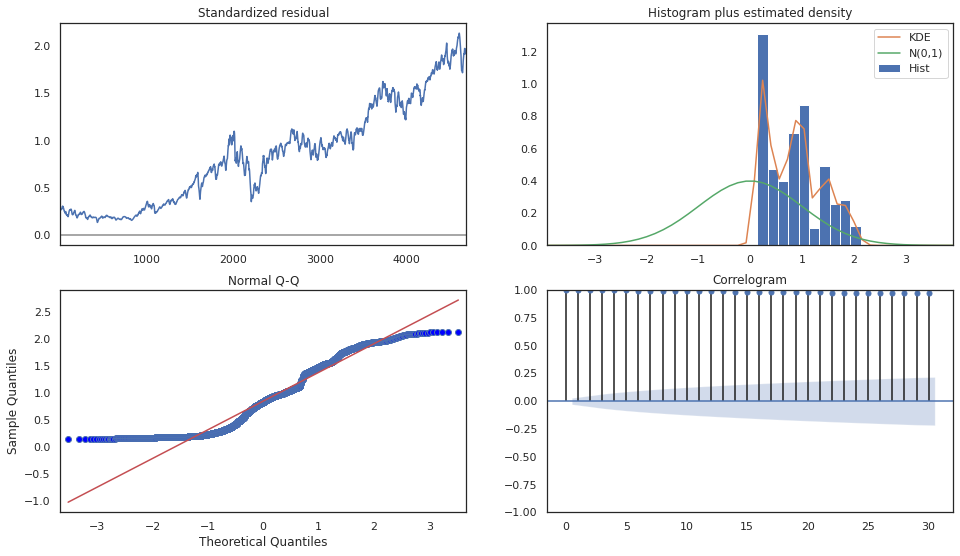

In [ ]:
# Plot diagnostics of auto-regressor model
fig = plt.figure(figsize=(16,9))
fig = res.plot_diagnostics(fig=fig, lags=30)



Interpretation of above plots :
* To ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean.
* In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

* Residuals are nearly normally distributed as KDE and N lines are closely followed but with different peaks.


* The qq-plot shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1) with slight deviations at times.

* The residuals over time don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot which shows that the time series residuals have low correlation with lagged versions of itself.


Those observations can be used conclude that our model produces a good fit that help us to understand our time series data and forecast future values.

## Arima

In [ ]:
# Import Auto-Arima algorithm
from pmdarima import auto_arima

In [ ]:
# Drop NAN values
df_1= df.copy()
df_1.dropna(inplace=True)

In [ ]:
df_1

,Open,High,Low,Close,Close First Difference
Date,,,,,
2000-01-04,1594.400000,1641.950000,1594.400000,1638.700000,46.500000
2000-01-05,1634.550000,1635.500000,1555.050000,1595.800000,-42.900000
2000-01-06,1595.800000,1639.000000,1595.800000,1617.600000,21.800000
2000-01-07,1616.600000,1628.250000,1597.200000,1613.300000,-4.300000
2000-01-10,1615.650000,1662.100000,1614.950000,1632.950000,19.650000
...,...,...,...,...,...
2021-05-04,14687.250000,14723.400391,14461.500000,14496.500000,-137.650391
2021-05-05,14604.150391,14637.900391,14506.599609,14617.849609,121.349609
2021-05-06,14668.349609,14743.900391,14611.500000,14724.799805,106.950196


In [ ]:
# Split data into Train and Test based on dates.Train data-before 2019 and Test data-After 2019
df_train = df_1[df_1.index < "2019"]
df_valid = df_1[df_1.index >= "2019"]

In [ ]:
df_valid

,Open,High,Low,Close,Close First Difference
Date,,,,,
2019-01-02,10868.849609,10895.349609,10735.049805,10792.500000,-70.049805
2019-01-03,10796.799805,10814.049805,10661.250000,10672.250000,-120.250000
2019-01-04,10699.700195,10741.049805,10628.650391,10727.349609,55.099609
2019-01-07,10804.849609,10835.950195,10750.150391,10771.799805,44.450196
2019-01-08,10786.250000,10818.450195,10733.250000,10802.150391,30.350586
...,...,...,...,...,...
2021-05-04,14687.250000,14723.400391,14461.500000,14496.500000,-137.650391
2021-05-05,14604.150391,14637.900391,14506.599609,14617.849609,121.349609
2021-05-06,14668.349609,14743.900391,14611.500000,14724.799805,106.950196


In [ ]:
# Fit data on Auto-Arima
model = auto_arima(df_train.Close, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.Close)

forecast = model.predict(n_periods=len(df_valid))
df_valid["Forecast_ARIMA"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=51998.045, Time=9.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=52024.279, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=52002.369, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=52001.908, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=52026.977, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=52005.678, Time=0.91 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=52001.223, Time=4.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=52005.189, Time=5.07 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=51990.871, Time=9.72 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=52002.725, Time=4.53 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=51992.703, Time=10.99 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=51992.539, Time=11.46 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=52002.946, Time=4.86 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=17.56 sec
 ARIMA(2,1,3)(0,0,0)[0

In [ ]:
# Create a new column in nifty_valid data
nifty_valid["Forecast_ARIMA"] = forecast

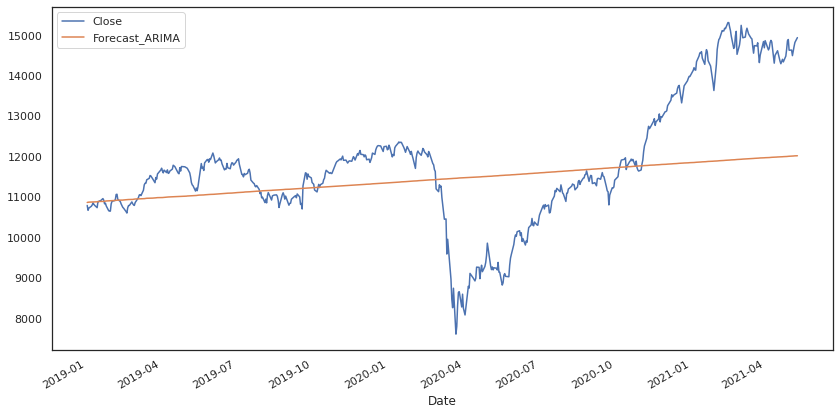

In [ ]:
# Plot Forecast  Close price and Close price graph to visualize
# df_train.plot(figsize=(14, 7))
df_valid[["Close", "Forecast_ARIMA"]].plot(figsize=(14, 7))

In [ ]:
# Create a new column in nifty_valid data
nifty_valid["Forecast_ARIMA"] = forecast

In [ ]:
# Importing Libraries

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

# Function to get MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

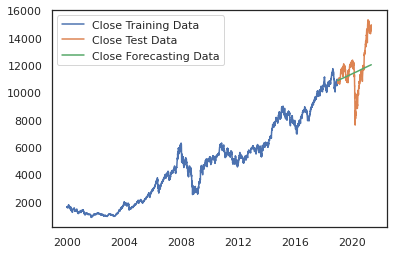

In [ ]:
# Plot forcasting Close price
forecast_df = pd.DataFrame(forecast,index = df_valid.index,columns=['Prediction'])
plt.plot(df_train['Close'],label='Close Training Data')
plt.plot(df_valid['Close'],label='Close Test Data')
plt.plot(forecast_df['Prediction'],label='Close Forecasting Data')
plt.legend()

In [ ]:
# Import evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("RMSE of Auto ARIMA:", np.sqrt(mean_squared_error(df_valid.Close, df_valid.Forecast_ARIMA)))
print("\nMAE of Auto ARIMA:", mean_absolute_error(df_valid.Close, df_valid.Forecast_ARIMA))

RMSE of Auto ARIMA: 1454.6100712933937

MAE of Auto ARIMA: 1070.1663173493503


In [ ]:
# Calculating error for Auto-Arima without exgenous features
print("mean absoulte percentage error:", round(mean_absolute_percentage_error(nifty_valid.Close, nifty_valid.Forecast_ARIMA),2),"%")

mean absoulte percentage error: 9.03 %


# Using ARIMAX for forcasting:

In [ ]:
final_df.dropna(inplace=True)

In [ ]:
# # Split data into Train and Test based on dates.Train data-before 2019 and Test data-After 2019
df_train = final_df[final_df.index < "2019"]
df_valid = final_df[final_df.index >= "2019"]

In [ ]:
# Set Date as index on train dataset
df_train.set_index('Date',inplace=True)

In [ ]:
# Set Date as index on test dataset
df_valid.set_index('Date',inplace=True)

In [ ]:
# Get exogenous features
exogenous_features

Index(['Close First Difference', 'High3_ma', 'High3_ewma', 'High7_ma',
       'High7_ewma', 'High15_ma', 'High15_ewma', 'High30_ma', 'High30_ewma',
       'Low3_ma', 'Low3_ewma', 'Low7_ma', 'Low7_ewma', 'Low15_ma',
       'Low15_ewma', 'Low30_ma', 'Low30_ewma', 'Open3_ma', 'Open3_ewma',
       'Open7_ma', 'Open7_ewma', 'Open15_ma', 'Open15_ewma', 'Open30_ma',
       'Open30_ewma', 'Close3_ma', 'Close3_ewma', 'Close7_ma', 'Close7_ewma',
       'Close15_ma', 'Close15_ewma', 'Close30_ma', 'Close30_ewma', 'Open1',
       'Open2', 'Open3', 'Open4', 'Open5', 'Close1', 'Close2', 'Close3',
       'Close4', 'Close5', 'High1', 'High2', 'High3', 'High4', 'High5', 'Low1',
       'Low2', 'Low3', 'Low4', 'Low5', 'Volatility'],
      dtype='object')

In [ ]:
# Fit training data on auto_arima model
model = auto_arima(df_train.Close, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.Close, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-14739.654, Time=305.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-21139.940, Time=55.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17442.589, Time=84.85 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-22472.957, Time=83.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11336.177, Time=68.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14700.394, Time=238.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-14615.194, Time=93.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-15086.553, Time=229.85 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-21474.491, Time=79.23 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1238.245 seconds


In [ ]:
nifty_valid["Forecast_ARIMAX"] = forecast

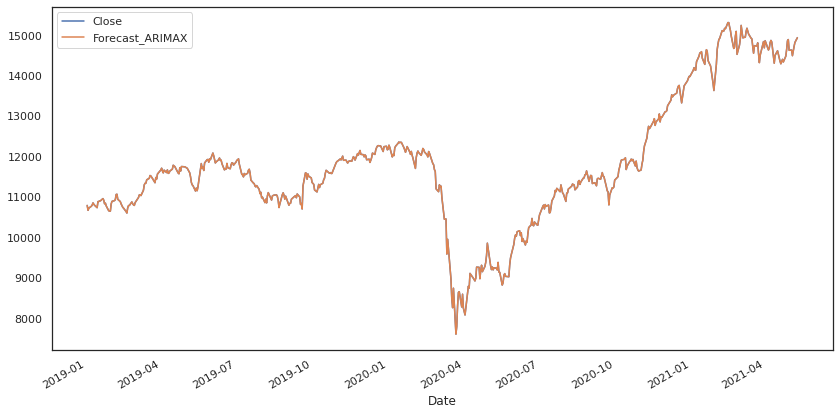

In [ ]:
# df_train.plot(figsize=(14, 7))
df_valid[["Close", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

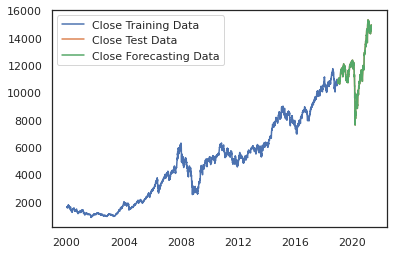

In [ ]:
# Plot forcasting Close price
forecast_df = pd.DataFrame(forecast,index = df_valid.index,columns=['Prediction'])
plt.plot(df_train['Close'],label='Close Training Data')
plt.plot(df_valid['Close'],label='Close Test Data')
plt.plot(forecast_df['Prediction'],label='Close Forecasting Data')
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.Close, df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.Close, df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 0.958438495954386

MAE of Auto ARIMAX: 0.7067783811437067


In [ ]:
# Calculating error for ARIMAX
print("mean absoulte percentage error:", round(mean_absolute_percentage_error(nifty_valid.Close, nifty_valid.Forecast_ARIMAX),2),"%")

mean absoulte percentage error: 0.01 %


## Facebook Prophet

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [ ]:
!pip install prophet

In [ ]:
# Reset date as index
df_train.reset_index(inplace=True)

In [ ]:
# Drop Open','High','Low' features
df_train.drop(['Open','High','Low'],axis=1,inplace= True)
df_train

,Date,Close,Close First Difference,High3_ma,High3_ewma,High7_ma,High7_ewma,High15_ma,High15_ewma,High30_ma,High30_ewma,Low3_ma,Low3_ewma,Low7_ma,Low7_ewma,Low15_ma,Low15_ewma,Low30_ma,Low30_ewma,Open3_ma,Open3_ewma,Open7_ma,Open7_ewma,Open15_ma,Open15_ewma,Open30_ma,Open30_ewma,Close3_ma,Close3_ewma,Close7_ma,Close7_ewma,Close15_ma,Close15_ewma,Close30_ma,Close30_ewma,Open1,Open2,Open3,Open4,Open5,Close1,Close2,Close3,Close4,Close5,High1,High2,High3,High4,High5,Low1,Low2,Low3,Low4,Low5,Volatility
0,2000-01-10,1632.950000,19.650000,1634.250000,1640.081051,1627.520000,1636.603694,1627.520000,1634.918149,1627.520000,1634.120163,1582.683333,1588.378037,1564.920000,1580.824376,1564.920000,1577.014746,1564.920000,1575.187525,1615.650000,1603.216172,1584.700000,1596.910458,1584.700000,1593.443128,1584.700000,1591.719104,1608.900000,1618.687793,1611.520000,1616.766314,1611.520000,1615.898784,1611.520000,1615.500867,1616.600000,1595.800000,1634.550000,1594.400000,1482.150000,1613.300000,1617.600000,1595.800000,1638.700000,1592.200000,1628.250000,1639.000000,1635.500000,1641.950000,1592.900000,1597.200000,1595.800000,1555.050000,1594.400000,1482.150000,47.150000
1,2000-01-11,1572.500000,-60.450000,1643.116667,1640.028816,1633.283333,1637.282165,1633.283333,1635.774728,1633.283333,1635.029250,1602.650000,1576.800630,1573.258333,1574.119668,1573.258333,1572.068940,1573.258333,1570.950632,1609.350000,1611.881281,1589.858333,1604.390142,1589.858333,1600.287516,1589.858333,1598.251329,1621.283333,1605.362076,1615.091667,1607.655081,1615.091667,1608.436804,1615.091667,1608.737436,1615.650000,1616.600000,1595.800000,1634.550000,1594.400000,1632.950000,1613.300000,1617.600000,1595.800000,1638.700000,1662.100000,1628.250000,1639.000000,1635.500000,1641.950000,1614.950000,1597.200000,1595.800000,1555.050000,1594.400000,91.650000
2,2000-01-12,1624.800000,52.300000,1643.416667,1637.673294,1634.228571,1636.190558,1634.228571,1635.119984,1634.228571,1634.542829,1586.800000,1575.383611,1569.685714,1573.658878,1569.685714,1572.011762,1569.685714,1571.055398,1621.833333,1600.885101,1596.057143,1598.279048,1596.057143,1595.950039,1596.057143,1594.623171,1606.250000,1610.762177,1609.007143,1610.920078,1609.007143,1610.972755,1609.007143,1610.983083,1633.250000,1615.650000,1616.600000,1595.800000,1634.550000,1572.500000,1632.950000,1613.300000,1617.600000,1595.800000,1639.900000,1662.100000,1628.250000,1639.000000,1635.500000,1548.250000,1614.950000,1597.200000,1595.800000,1555.050000,59.850000
3,2000-01-13,1621.400000,-3.400000,1644.516667,1646.721881,1639.750000,1642.439188,1633.893750,1640.231199,1633.893750,1639.163766,1578.300000,1585.726825,1582.478571,1580.806867,1569.937500,1577.918559,1569.937500,1576.432132,1607.066667,1608.173579,1608.935714,1603.564542,1593.087500,1600.475365,1593.087500,1598.817407,1610.083333,1613.637528,1613.664286,1612.793253,1610.981250,1612.451963,1610.981250,1612.298014,1572.300000,1633.250000,1615.650000,1616.600000,1595.800000,1624.800000,1572.500000,1632.950000,1613.300000,1617.600000,1631.550000,1639.900000,1662.100000,1628.250000,1639.000000,1571.700000,1548.250000,1614.950000,1597.200000,1595.800000,57.500000
4,2000-01-14,1622.750000,1.350000,1647.533333,1641.603157,1643.921429,1639.888182,1638.033333,1638.544798,1638.033333,1637.806379,1577.866667,1587.229754,1585.228571,1582.603715,1574.794444,1579.690420,1574.794444,1578.159232,1611.133333,1611.876191,1613.714286,1606.717080,1596.950000,1603.324055,1596.950000,1601.509689,1606.233333,1616.051590,1611.192857,1614.482155,1612.138889,1613.805431,1612.138889,1613.504040,1627.850000,1572.300000,1633.250000,1615.650000,1616.600000,1621.400000,1624.800000,1572.500000,1632.950000,1613.300000,1671.150000,1631.550000,1639.900000,1662.100000,1628.250000,1613.650000,1571.700000,1548.250000,1614.950000,1597.200000,36.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:
#Renaming columns
fb_df = df_train.rename(columns={"Date": "ds", "Close": "y"})

In [ ]:
# Import Prophet library
from prophet import Prophet


In [ ]:
# Fiting model
m = Prophet()
m.fit(fb_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Making data frame for future dates
future = m.make_future_dataframe(periods=800)
future.tail()
forecast = m.predict(future)

In [ ]:
future_forecast = forecast

In [ ]:
df_valid = df_valid.reset_index()

In [ ]:
# Predicting for future dates
forecast = m.predict(df_valid.rename(columns={"Date": "ds", "Close": "y"}))
nifty_valid["Forecast_Prophet"] = forecast.yhat.values
x = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


In [ ]:
nifty_valid.head()

In [ ]:
# Get plots on future forecasts
from prophet.plot import plot_plotly, plot_components_plotly
plot_components_plotly(m, future_forecast)

The plots show that trends of decreasing from monday to saturday and january to december.

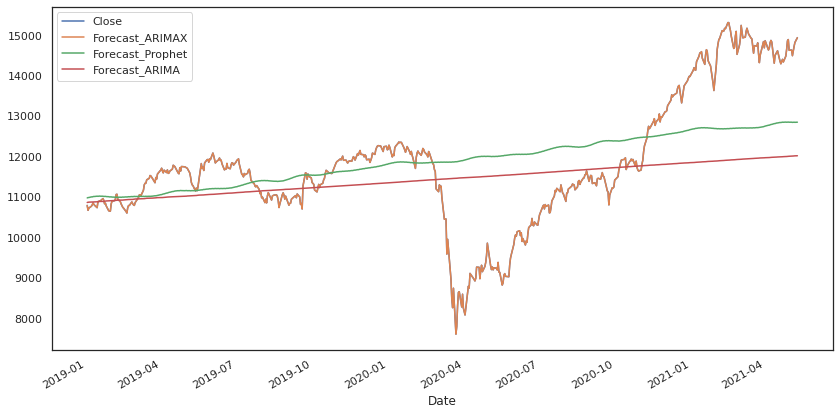

In [ ]:
# Get a comparison plot for forecasts made by different algorithm
nifty_valid[["Close", "Forecast_ARIMAX", "Forecast_Prophet","Forecast_ARIMA"]].plot(figsize=(14, 7))


In [ ]:
# print("mean absoulte percentage error:", round(mean_absolute_percentage_error(nifty_valid.Close, nifty_valid.Forecast_Prophet),2),"%")
print("mean absoulte percentage error of Prophet:", round(mean_absolute_percentage_error(nifty_valid.Close, nifty_valid.Forecast_Prophet),2),"%")
print("mean absoulte percentage error of ARIMA:", round(mean_absolute_percentage_error(nifty_valid.Close, nifty_valid.Forecast_ARIMA),2),"%")
print("mean absoulte percentage error of ARIMAX:", round(mean_absolute_percentage_error(nifty_valid.Close, nifty_valid.Forecast_ARIMAX),2),"%")

mean absoulte percentage error of Prophet: 8.87 %
mean absoulte percentage error of ARIMA: 9.03 %
mean absoulte percentage error of ARIMAX: 0.01 %


## Residual Analysis

In [ ]:
# Get residuals
residuals_Prophet=nifty_valid.Close-nifty_valid.Forecast_Prophet
residuals_ARIMAX=nifty_valid.Close-nifty_valid.Forecast_ARIMAX

residuals_ARIMA=nifty_valid.Close-nifty_valid.Forecast_ARIMA


In [ ]:
# Check stationary of residuals by Prophet model
adfuller_test((residuals_Prophet))


ADF Test Statistic : -1.1691986326143236
p-value : 0.6867034022170799
#Lags Used : 7
Number of Observations : 568
weak evidence against null hypothesis,indicating it is non-stationary 


In [ ]:
# Check stationary of residuals by ARIMAX model
adfuller_test((residuals_ARIMAX))


ADF Test Statistic : 0.4359515738354085
p-value : 0.9827907444298098
#Lags Used : 13
Number of Observations : 562
weak evidence against null hypothesis,indicating it is non-stationary 


In [ ]:
# Check stationary of residuals by ARIMA model
adfuller_test((residuals_ARIMA))


ADF Test Statistic : -0.9980502516976268
p-value : 0.7539747626330369
#Lags Used : 7
Number of Observations : 568
weak evidence against null hypothesis,indicating it is non-stationary 


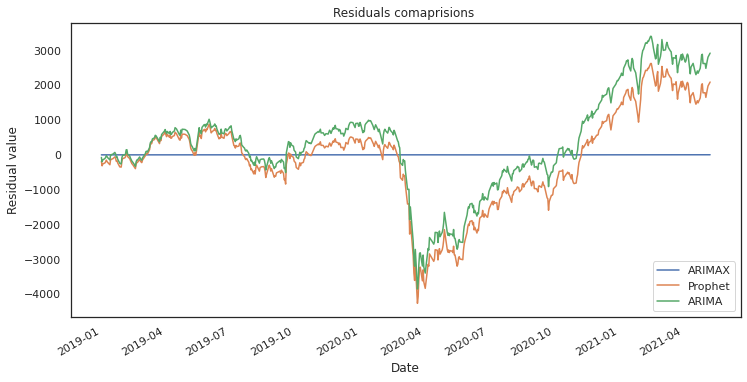

In [ ]:
# Get plots of different residuals by different models
plt.title("Residuals comaprisions ")
plt.xlabel('Years')
plt.ylabel('Residual value')
residuals_ARIMAX.plot(label='ARIMAX',figsize=(12,6))
residuals_Prophet.plot(label='Prophet')
residuals_ARIMA.plot(label='ARIMA')
plt.legend(loc='lower right')


# Approching the problem by Classifaction

We though of approaching the problem as just predicting the direction of Close price next day. will our Closing price will increase or decrease the next day.



Understanding target variable
* 1 mean that close price have increase today from yesterday
* 0 = close price have decreased today from yesterday

In [ ]:
# Creating target variables
final_df.loc[(final_df['Close']-final_df['Close'].shift(1)) < 0,'Target']=0
final_df.loc[(final_df['Close']-final_df['Close'].shift(1)) >= 0,'Target']=1

In [ ]:
# Get count of each classes in Target class
final_df.Target.value_counts()

1.0    2837
0.0    2423
Name: Target, dtype: int64

In [ ]:
# Drop NAN values
final_df.dropna(inplace =True)

In [ ]:
final_df

,Open,High,Low,Close,Close First Difference,High3_ma,High3_ewma,High7_ma,High7_ewma,High15_ma,High15_ewma,High30_ma,High30_ewma,Low3_ma,Low3_ewma,Low7_ma,Low7_ewma,Low15_ma,Low15_ewma,Low30_ma,Low30_ewma,Open3_ma,Open3_ewma,Open7_ma,Open7_ewma,Open15_ma,Open15_ewma,Open30_ma,Open30_ewma,Close3_ma,Close3_ewma,Close7_ma,Close7_ewma,Close15_ma,Close15_ewma,Close30_ma,Close30_ewma,Open1,Open2,Open3,Open4,Open5,Close1,Close2,Close3,Close4,Close5,High1,High2,High3,High4,High5,Low1,Low2,Low3,Low4,Low5,Volatility,Target
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-11,1633.250000,1639.900000,1548.250000,1572.500000,-60.450000,1643.116667,1640.028816,1633.283333,1637.282165,1633.283333,1635.774728,1633.283333,1635.029250,1602.650000,1576.800630,1573.258333,1574.119668,1573.258333,1572.068940,1573.258333,1570.950632,1609.350000,1611.881281,1589.858333,1604.390142,1589.858333,1600.287516,1589.858333,1598.251329,1621.283333,1605.362076,1615.091667,1607.655081,1615.091667,1608.436804,1615.091667,1608.737436,1615.650000,1616.600000,1595.800000,1634.550000,1594.400000,1632.950000,1613.300000,1617.600000,1595.800000,1638.700000,1662.100000,1628.250000,1639.000000,1635.500000,1641.950000,1614.950000,1597.200000,1595.800000,1555.050000,1594.400000,91.650000,0.0
2000-01-12,1572.300000,1631.550000,1571.700000,1624.800000,52.300000,1643.416667,1637.673294,1634.228571,1636.190558,1634.228571,1635.119984,1634.228571,1634.542829,1586.800000,1575.383611,1569.685714,1573.658878,1569.685714,1572.011762,1569.685714,1571.055398,1621.833333,1600.885101,1596.057143,1598.279048,1596.057143,1595.950039,1596.057143,1594.623171,1606.250000,1610.762177,1609.007143,1610.920078,1609.007143,1610.972755,1609.007143,1610.983083,1633.250000,1615.650000,1616.600000,1595.800000,1634.550000,1572.500000,1632.950000,1613.300000,1617.600000,1595.800000,1639.900000,1662.100000,1628.250000,1639.000000,1635.500000,1548.250000,1614.950000,1597.200000,1595.800000,1555.050000,59.850000,1.0
2000-01-13,1627.850000,1671.150000,1613.650000,1621.400000,-3.400000,1644.516667,1646.721881,1639.750000,1642.439188,1633.893750,1640.231199,1633.893750,1639.163766,1578.300000,1585.726825,1582.478571,1580.806867,1569.937500,1577.918559,1569.937500,1576.432132,1607.066667,1608.173579,1608.935714,1603.564542,1593.087500,1600.475365,1593.087500,1598.817407,1610.083333,1613.637528,1613.664286,1612.793253,1610.981250,1612.451963,1610.981250,1612.298014,1572.300000,1633.250000,1615.650000,1616.600000,1595.800000,1624.800000,1572.500000,1632.950000,1613.300000,1617.600000,1631.550000,1639.900000,1662.100000,1628.250000,1639.000000,1571.700000,1548.250000,1614.950000,1597.200000,1595.800000,57.500000,0.0
2000-01-14,1622.150000,1627.400000,1591.400000,1622.750000,1.350000,1647.533333,1641.603157,1643.921429,1639.888182,1638.033333,1638.544798,1638.033333,1637.806379,1577.866667,1587.229754,1585.228571,1582.603715,1574.794444,1579.690420,1574.794444,1578.159232,1611.133333,1611.876191,1613.714286,1606.717080,1596.950000,1603.324055,1596.950000,1601.509689,1606.233333,1616.051590,1611.192857,1614.482155,1612.138889,1613.805431,1612.138889,1613.504040,1627.850000,1572.300000,1633.250000,1615.650000,1616.600000,1621.400000,1624.800000,1572.500000,1632.950000,1613.300000,1671.150000,1631.550000,1639.900000,1662.100000,1628.250000,1613.650000,1571.700000,1548.250000,1614.950000,1597.200000,36.000000,1.0
2000-01-17,1623.500000,1668.450000,1604.650000,1611.600000,-11.150000,1643.366667,1648.610838,1642.764286,1644.525992,1636.970000,1642.221776,1636.970000,1641.070884,1592.250000,1591.776863,1590.421429,1586.183546,1576.455000,1582.759311,1576.455000,1580.981329,1607.433333,1614.910289,1611.942857,1609.442256,1599.470000,1605.804777,1599.470000,1603.852346,1622.983333,1614.889616,1615.042857,1614.014157,1613.200000,1613.534263,1613.200000,1613.301200,1622.150000,1627.850000,1572.300000,1633.250000,1615.650000,1622.750000,1621.400000,1624.800000,1572.500000,1632.950000,1627.400000,1671

## Let's see how our target value have varied

Visualization of Dependent variables

In [ ]:
GB = final_df.groupby([final_df.index.year])

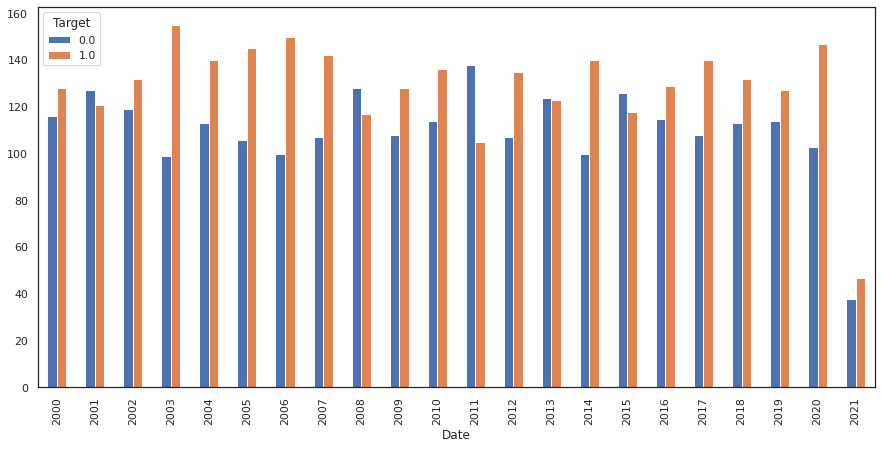

In [ ]:
# Get distribution of each target class across years
GB['Target'].value_counts().unstack().plot(kind= 'bar',figsize=(15,7))

This bar plot represent the total number of up and down seen in each  year of past 21 years
as in year 2008 due to downfall of market we can see that close price decreased more each day.


2000


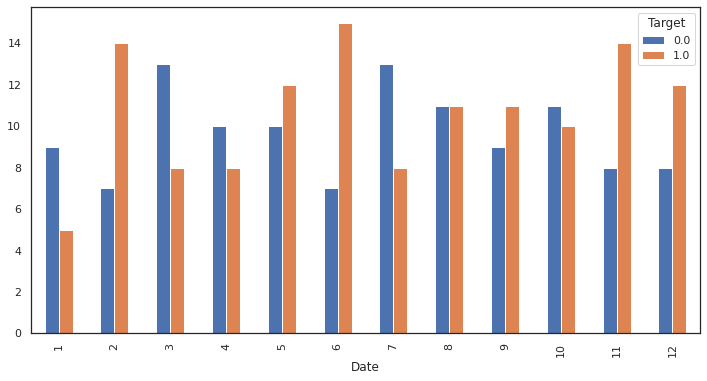

2001


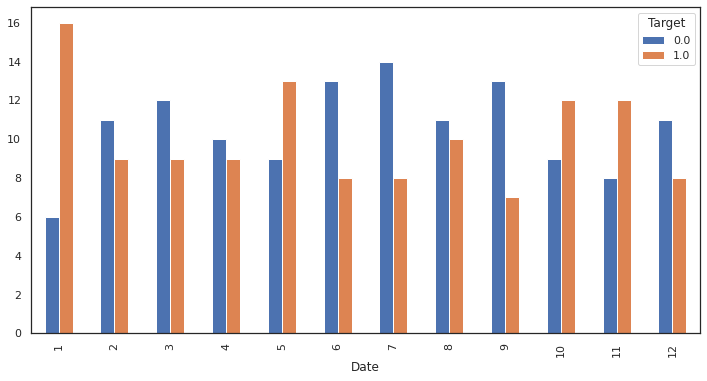

2002


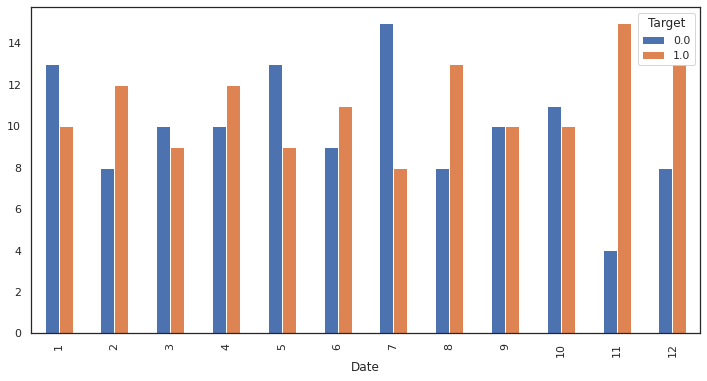

2003


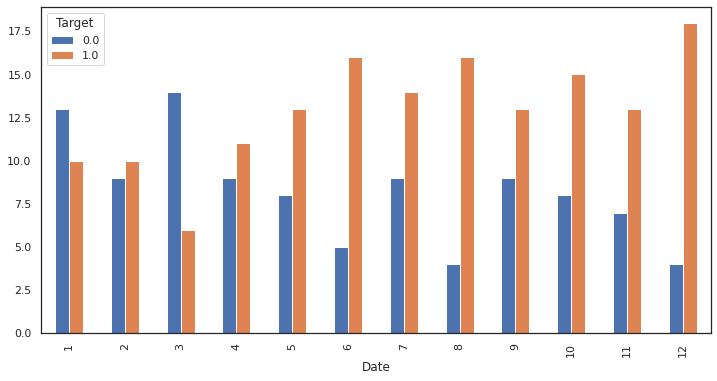

2004


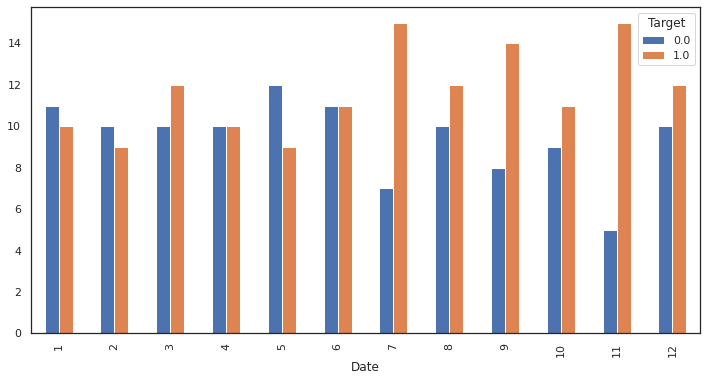

2005


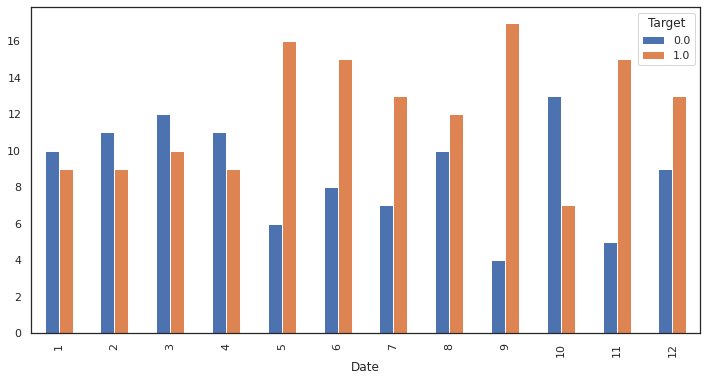

2006


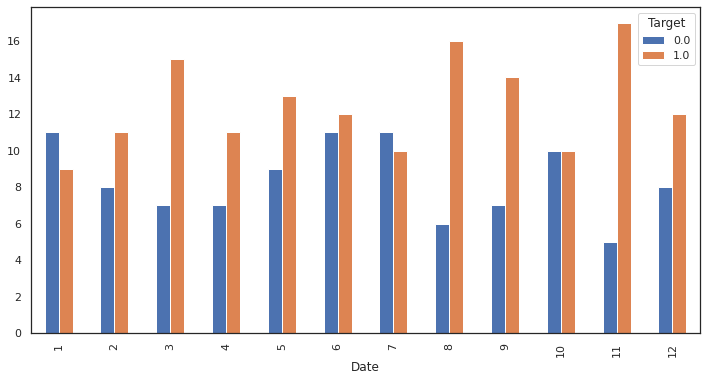

2007


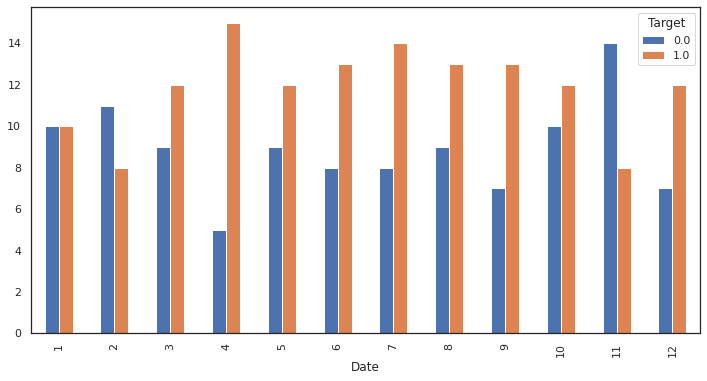

2008


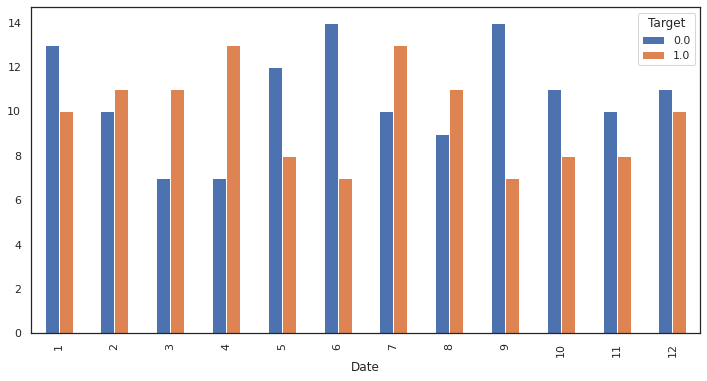

2009


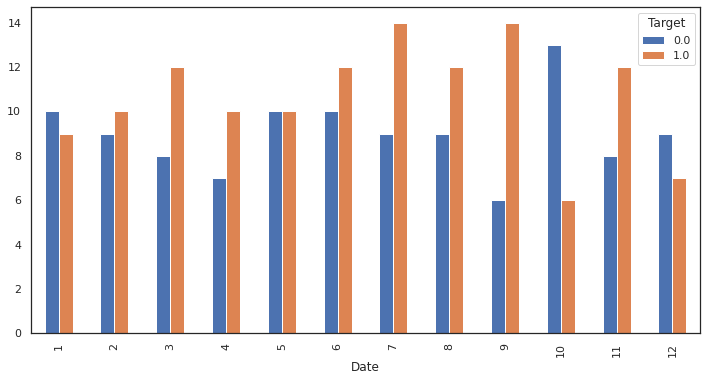

2010


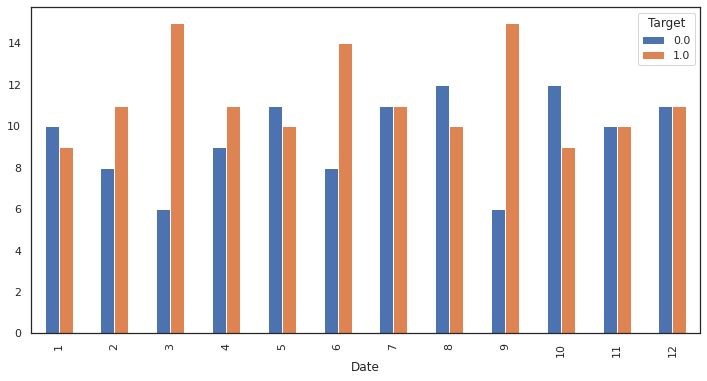

2011


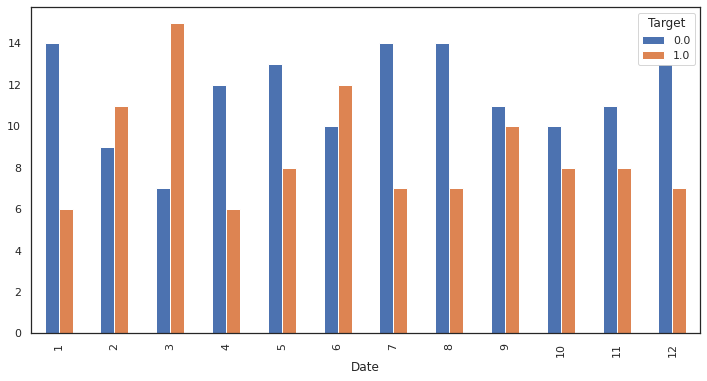

2012


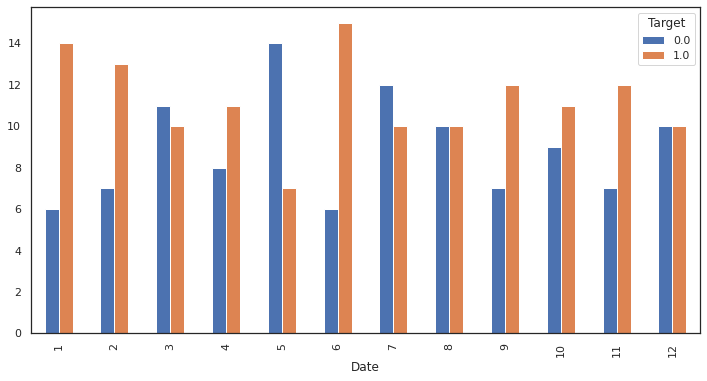

2013


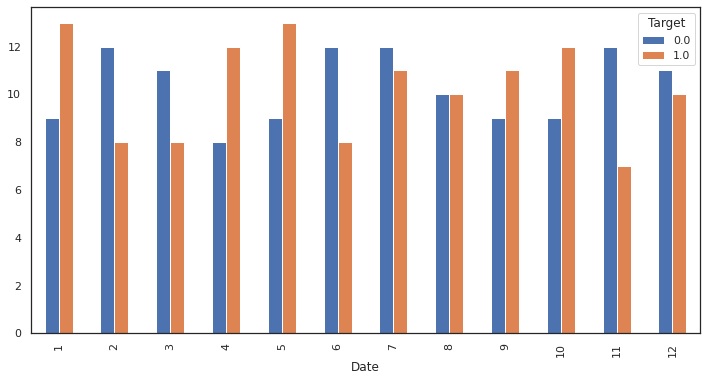

2014


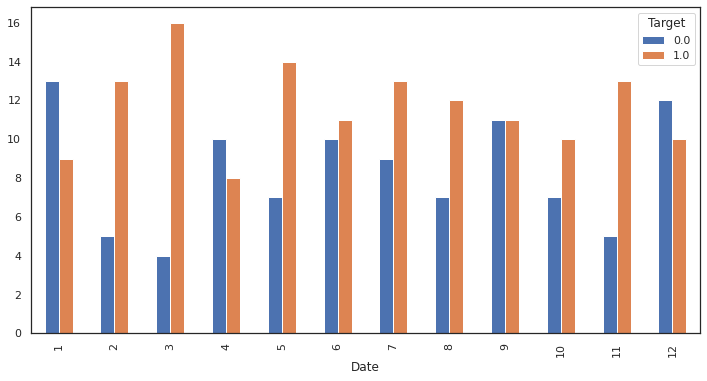

2015


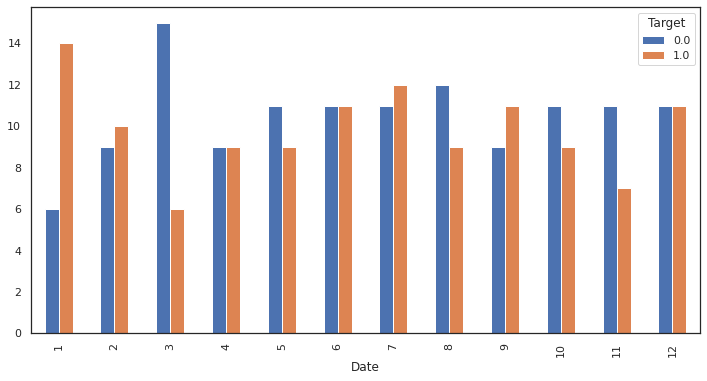

2016


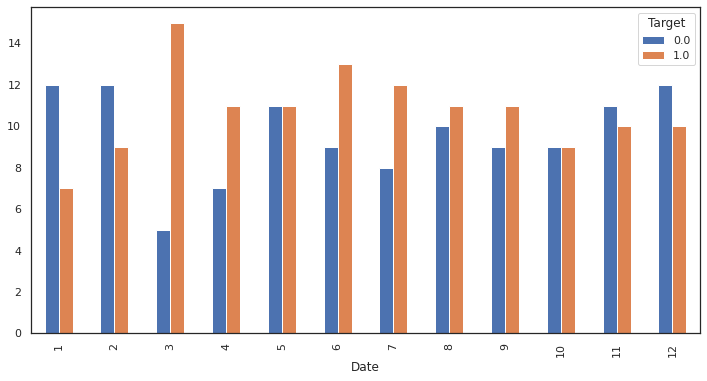

2017


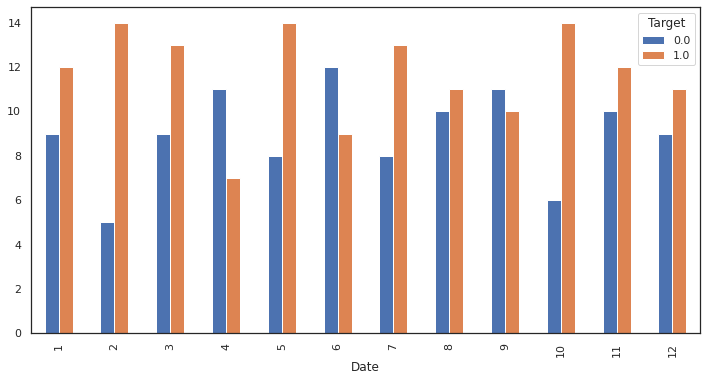

2018


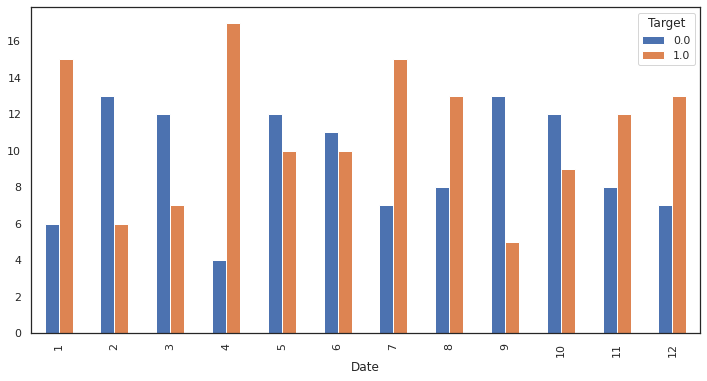

2019


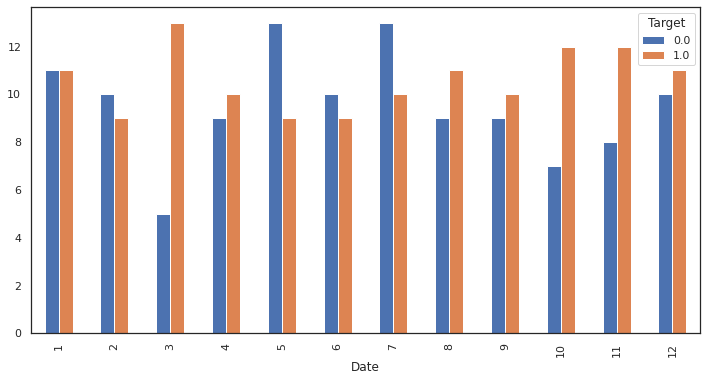

2020


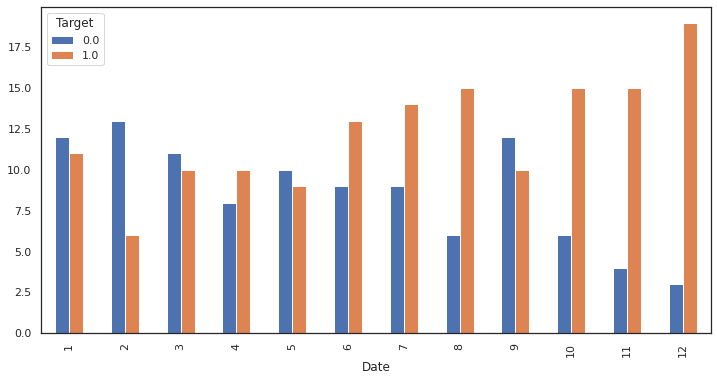

2021


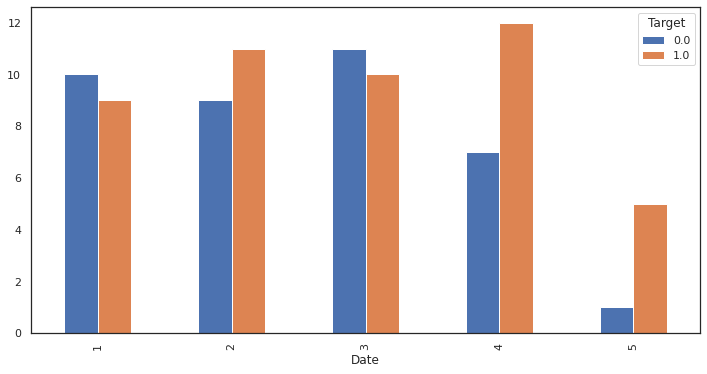

In [ ]:
# Get distribution of each target class across years' different months
for year, year_df in GB:
  print(year)

  year_df.groupby([year_df.index.month])['Target'].value_counts().unstack().plot(kind='bar',figsize=(12,6))
  plt.show()



here we have bar plot which represent how our target value  varied in each month.

#### Corelation of independent feature and dependent features

In [ ]:
# Get correlation matrix on the dataset
cor_matrix =abs( final_df.corr())

In [ ]:
# Get heatmap of correlation matrix on the dataset
plt.figure(figsize=(20,10))
sns.heatmap(cor_matrix,annot = True)

In [ ]:
#  Sort correlation of features with target variable
cor_matrix['Target'].sort_values(ascending=False)

Spliting data into test ,train and validation sets

In [ ]:
# Function to split data into test ,train and validation
def temporal_splitting(data,date1,date2,date3):
    train=data.loc[(data.index >= date1) & (data.index < date2)]
    val=data.loc[(data.index >= date2) & (data.index < date3),:]
    test=data.loc[data.index >= date3]

    return train, val, test

We tried to divide my training validation nad test data as

* 16 years for training
* 3 year for validation
* 2 years for testing

In [ ]:
# Split the datset into various sets of data viz. test ,train and validation sets based on date
train, val,test=temporal_splitting(final_df,'2000-01-01','2016-01-01','2019-06-01')

Disrtibution for test , valiodatiuon and test

In [ ]:
train.shape,val.shape,test.shape

# Finding independent and dependent variables

In [ ]:
ind_var= final_df.columns.drop(['Target','Open','Low','High','Close','Close First Difference'])

In [ ]:
ind_var

In [ ]:
dept_var=['Target']

Defining training data ,Validation data and Test data

In [ ]:
X_train= train[ind_var]
X_val = val[ind_var]
X_test = test[ind_var]

y_train= train[dept_var]
y_val = val[dept_var]
y_test = test[dept_var]

#### Obtaining the distribution of classes of dependent variable across three datasets

In [ ]:
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

In [ ]:
pip install bayesian-optimization

### Building LGB classifier model

Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks.

Since it is based on decision tree algorithms, it splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. Also, it is surprisingly very fast, hence the word ‘Light’.



In [ ]:
# Import Libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb
import lightgbm as lgb
import bayes_opt as bayso
from sklearn.metrics import accuracy_score,confusion_matrix

In [ ]:
# Function to set parameters
def lgbcv1(min_child_weight,
           colsample_bytree,
           max_depth,
           subsample,
           min_gain_to_split,
           reg_alpha,
           reg_lambda):

    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting': 'gbdt',
        'random_state' : 501, # Updated from 'seed'
        'n_estimators' : 200,
        'learning_rate': 0.1,
        'early_stopping_round' : 10,
        'verbose': 20,
        'num_leaves': 65,
        'min_data_in_leaf': 500,
        'bagging_freq': 1,
        'bagging_seed': RS,
        'feature_fraction_seed': RS,
        'max_bin': 50,
        'min_child_weight': int(min_child_weight),
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_depth': int(max_depth),
        'subsample': max(min(subsample, 1), 0),
        'min_gain_to_split': max(min_gain_to_split,0),
        'reg_alpha': max(reg_alpha,0),
        'reg_lambda': max(reg_lambda,0)
    }


    cv_result = lgb.cv(params, lgtrain, nfold=5, seed=0, verbose_eval =200,stratified=False,shuffle=False)

    return max(cv_result['auc-mean'])

In [ ]:
# Function to prepare data
def prepare_data():
    lgtrain = lgb.Dataset(X_train, label=y_train)

    return lgtrain

In [ ]:
if __name__ == '__main__':
    lgtrain =  prepare_data()
    random_state = 2020
    init_points = 30
    numitems=30
    RS = 20200801
    np.random.seed(RS)
    lgbo = bayso.BayesianOptimization(lgbcv1,
                                      {'min_child_weight': (300, 500),
                                      'colsample_bytree': (0.4, 0.7),
                                      'max_depth': (5, 7),
                                      'subsample': (0.3, 1.0),
                                      'min_gain_to_split': (0, 20),
                                      'reg_alpha': (0, 20),
                                      'reg_lambda': (0, 50)})

    lgbo.maximize(init_points=init_points, n_iter=numitems)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ga... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.5      |  0.4603   |  5.062    |  474.1    |  11.19    |  7.148    |  30.44    |  0.6636   |
|  2        |  0.5      |  0.6902   |  6.263    |  348.6    |  8.939    |  10.7     |  2.311    |  0.8914   |
|  3        |  0.5      |  0.4887   |  6.797    |  380.1    |  2.816    |  8.328    |  21.9     |  0.6081   |
|  4        |  0.5      |  0.5725   |  5.936    |  368.6    |  6.13     |  16.36    |  45.21    |  0.6501   |
|  5        |  0.5      |  0.6037   |  5.237    |  438.9    |  8.696    |  3.617    |  34.67    |  0.831    |
|  6        |  0.5      |  0.6919   |  6.411    |  417.9    |  11.27    |  2.935    |  30.42    |  0.8017   |
|  7        |  0.5      |  0.6413   |  5.78     |  312.0    |  5.647    |  10.57    |  24.62    |  0.709    |
|  8      

In [ ]:
len(lgbo.res)

### Finding optimal set of parameters

In [ ]:
max_target=max([lgbo.res[elem]['target'] for elem in range(len(lgbo.res))])
opt_params=[elem['params'] for elem in lgbo.res if elem['target']==max_target][0]

### Updating the model parameters

In [ ]:
opt_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'gbdt',
    'random_state' : 501, # Updated from 'seed'
    'n_estimators' : 200,
    'learning_rate': 0.1,
    'early_stopping_round' : 10,
    'verbose': 20,
    'num_leaves': 65,
    'min_data_in_leaf': 500,
    'bagging_freq': 1,
    'bagging_seed': RS,
    'feature_fraction_seed': RS,
    'max_bin': 50})
opt_params['min_child_weight'] = int(opt_params['min_child_weight'])
opt_params['colsample_bytree'] = max(min(opt_params['colsample_bytree'], 1), 0)
opt_params['max_depth'] = int(opt_params['max_depth'])
opt_params['subsample'] = max(min(opt_params['subsample'], 1), 0)
opt_params['min_gain_to_split'] = max(opt_params['min_gain_to_split'],0)
opt_params['reg_alpha'] = max(opt_params['reg_alpha'],0)
opt_params['reg_lambda'] = max(opt_params['reg_lambda'],0)

In [ ]:
# Get optimal parameters
opt_params

### Training the model on our optimal set of parameters

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [ ]:
lgb_model = lgb.train(opt_params, lgb_train, valid_sets=lgb_eval)

### Getting model probabilities on the three datasets

In [ ]:
train_preds_lgb=lgb_model.predict(X_train)
val_preds_lgb=lgb_model.predict(X_val)
test_preds_lgb=lgb_model.predict(X_test)

### Evaluating model performance using metrics like roc-auc and confusion matrix

In [ ]:
# Convert the probs to classes
train_preds_lgb = np.where(train_preds_lgb > 0.5,1,0)
val_preds_lgb   = np.where(val_preds_lgb > 0.5,1,0)
test_preds_lgb  = np.where(test_preds_lgb > 0.5,1,0)

In [ ]:
print(accuracy_score(y_train,train_preds_lgb))
print(accuracy_score(y_val,val_preds_lgb))
print(accuracy_score(y_test,test_preds_lgb))

0.5591588548264504
0.5734767025089605
0.46638655462184875


In [ ]:
# Confusion Matrix
conf_matrix_train = confusion_matrix(y_train,train_preds_lgb)
conf_matrix_val = confusion_matrix(y_val,val_preds_lgb)
conf_matrix_test = confusion_matrix(y_test,test_preds_lgb)
print("The Confusion Matrix for Train Set \n",conf_matrix_train)
print("\n")
print("The Confusion Matrix for Validation Set \n",conf_matrix_val)
print("\n")
print("The Confusion Matrix for Test Set \n",conf_matrix_test)

The Confusion Matrix for Train Set 
 [[ 458 1374]
 [ 366 1749]]


The Confusion Matrix for Validation Set 
 [[265 119]
 [238 215]]


The Confusion Matrix for Test Set 
 [[203   4]
 [250  19]]


### Feature Importance analysis using shap

In [ ]:
pip install shap

In [ ]:
import shap


Feature importance on Training set

In [ ]:
# Get feature importance on training data
X_shap=X_train
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_shap)

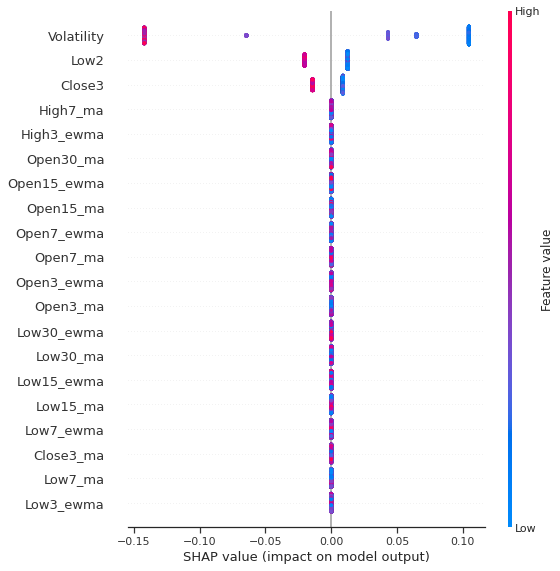

In [ ]:
shap.summary_plot(shap_values[1], X_shap, plot_type="dot")

**1 = close price  increase**

**0 = close price  decrease**

Here with this shap plot we can understand that
*  ***Higher the value of volatility  means that close price will be higher than previous day***
*  whereas higher exponential weighted moving avg will give mean  that price will decrease

Feature importance in validation set

In [ ]:
# Get feature importance on Validation data
X_shap=X_val
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_shap)

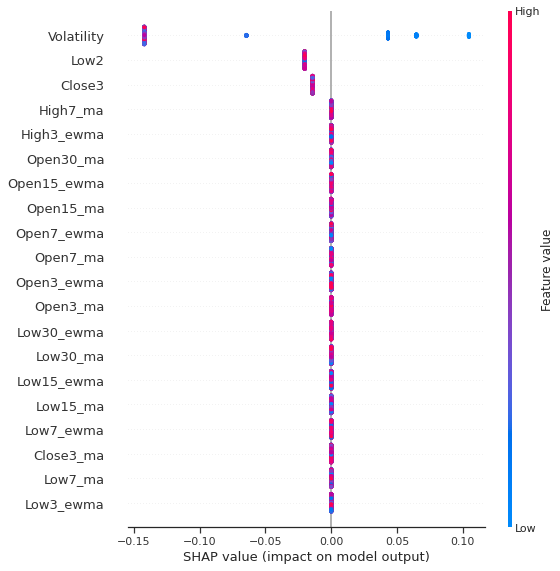

In [ ]:
shap.summary_plot(shap_values[1], X_shap, plot_type="dot")

##Feature importance in training set

In [ ]:
# Get feature importance on test data
X_shap=X_test
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_shap)

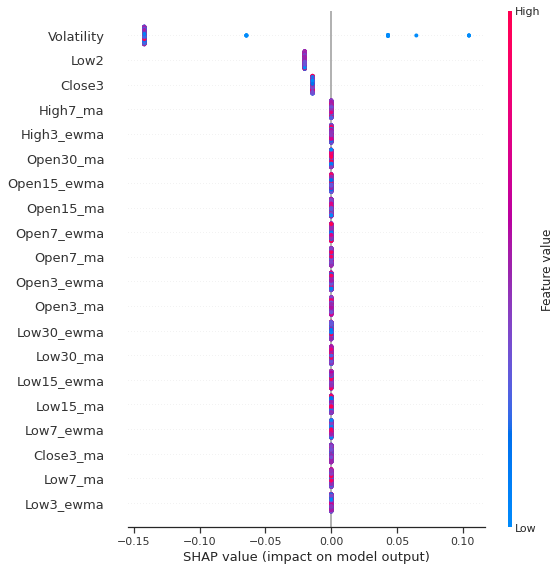

In [ ]:
shap.summary_plot(shap_values[1], X_shap, plot_type="dot")

##Building an XGB Classifier

XGBoost is a tree based ensemble machine learning algorithm which has higher predicting power and performance and it is achieved by improvisation on Gradient Boosting framework by introducing some accurate approximation algorithms. XGB commonly used and frequently makes its way to the top of the leaderboard of competitions in data science. XGBoost

In [ ]:
# Import Libraries
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate    #Additional scklearn functions

from sklearn.model_selection import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [ ]:
# Fit data on XGBClassifier
import xgboost as xgb
tscv = TimeSeriesSplit(5)
xgb_model = xgb.XGBClassifier(gamma=20)
parameters = {'objective' :['binary:logistic'],
             'learning_rate' : [0.1,0.3],
             'max_depth' : [3,6]}

xgb_fit = GridSearchCV(xgb_model,parameters,n_jobs=-1,cv=tscv,scoring='neg_log_loss',verbose=20,refit=True)
xgb_fit.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=20,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3], 'max_depth': [3, 6],
                         'objective': ['bin

In [ ]:
# Get best parameters
xgb_classifier = xgb_fit.best_estimator_
xgb_classifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=20,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Function to predict using different classifier
def get_predictions(classifier):
    train_preds = classifier.predict(X_train)
    val_preds = classifier.predict(X_val)
    test_preds = classifier.predict(X_test)

    return train_preds,val_preds,test_preds

In [ ]:
# Function to evaluate model performance

def evaluate_model(classifier):

     # Get the class model predictions
    train_preds = get_predictions(classifier)[0]
    val_preds = get_predictions(classifier)[1]
    test_preds = get_predictions(classifier)[2]

    # Calculate, accuracy and auc on train data
    train_accuracy = accuracy_score(y_train,train_preds)
    train_auc = roc_auc_score(y_train,train_preds)

    # Calculate, accuracy, and auc on val data
    val_accuracy = accuracy_score(y_val,val_preds)
    val_auc = roc_auc_score(y_val,val_preds)

    # Calculate, accuracyand auc on train data
    test_accuracy = accuracy_score(y_test,test_preds)
    test_auc = roc_auc_score(y_test,test_preds)

    # Print the results for train
    print("Performance on train data ")
    print("Accuracy : " ,train_accuracy)
    print("AUC ROC Score : ", train_auc)
    print("\n")

    # Print the results for validation
    print("Performance on validation data ")
    print("Accuracy : " ,val_accuracy)
    print("AUC ROC Score : ", val_auc)
    print("\n")

    # Print the results for test
    print("Performance on test data ")
    print("Accuracy : " ,test_accuracy)
    print("AUC ROC Score : ", test_auc)
    print("\n")

In [ ]:
# Evaluate model performance using xgb_classifier
evaluate_model(xgb_classifier)

Performance on train data 
Accuracy :  0.5611857106663288
AUC ROC Score :  0.5334277927467559


Performance on validation data 
Accuracy :  0.5866188769414575
AUC ROC Score :  0.5597923565121412


Performance on test data 
Accuracy :  0.5462184873949579
AUC ROC Score :  0.5589856868344019




In [ ]:
# Confusion Matrix
# Get the class model predictions
train_preds_xgb = get_predictions(xgb_classifier)[0]
val_preds_xgb = get_predictions(xgb_classifier)[1]
test_preds_xgb = get_predictions(xgb_classifier)[2]

conf_matrix_train = confusion_matrix(y_train,train_preds_xgb)
conf_matrix_val = confusion_matrix(y_val,val_preds_xgb)
conf_matrix_test = confusion_matrix(y_test,test_preds_xgb)
print("The Confusion Matrix for Train Set \n",conf_matrix_train)
print("\n")
print("The Confusion Matrix for Validation Set \n",conf_matrix_val)
print("\n")
print("The Confusion Matrix for Test Set \n",conf_matrix_test)

The Confusion Matrix for Train Set 
 [[ 268 1564]
 [ 168 1947]]


The Confusion Matrix for Validation Set 
 [[ 90 294]
 [ 52 401]]


The Confusion Matrix for Test Set 
 [[136  71]
 [145 124]]


In [ ]:
pip install scikit-plot

## Comparing ROC curves for Classifiers

In [ ]:
# Import evaluation metric
from sklearn.metrics import roc_curve



In [ ]:
# fpr and tpr for LGB Model on testing set
fpr_lgb, tpr_lgb,thersholds_lgb= roc_curve(y_test,test_preds_lgb)

In [ ]:
# fpr , tpr for XGB Model on testing set
fpr_xgb, tpr_xgb,thresholds_xgb = roc_curve(y_test,test_preds_xgb)


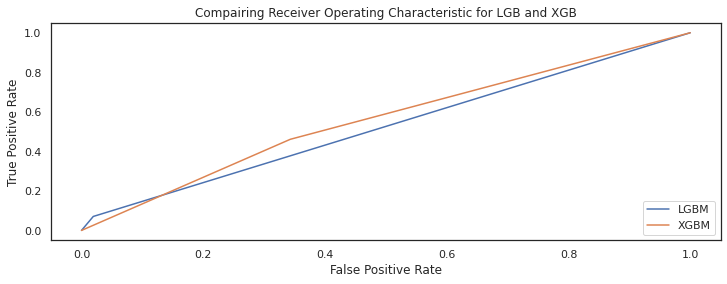

In [ ]:
# Get AUC-ROC curve for different classifer models
plt.plot(fpr_lgb,tpr_lgb,label='LGBM')
plt.plot(fpr_xgb,tpr_xgb,label='XGBM')
plt.legend(loc='lower right')
plt.title('Compairing Receiver Operating Characteristic for LGB and XGB')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


From above graph we can see that XGBM is performing better than LGBM
* AUC for XGBM is higher than AUC of LGBM

Conclusion:
* While using regression models,residuals are quite high.
* Difficult to predict effective numerical target value using regression models.
* While using classification models, we are have higher chance of predicting the outcome.


Improvement to the model prediction:
* Forecast for more than 1 day for unseen data.
* More features can be included to increase model efficiency.
